# Temporal and activity profile and engagement (figure 1)



In this notebook we perform the binarization of the data set, then we compute the temporal scale evolution of the system in different windows of time and we show how these two measures correlates. Further more we define temporal and activity engagement, and we show that again these two measure correlates significantly.

In [1]:

import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
from lempel_ziv_complexity import lempel_ziv_complexity

import saving as sv
import mattepy as mp
import utils_avalanches as av
import Utils_FC as fc

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS


In [2]:

def acfun(x, maxdel=100):
    return np.array([1]+[np.corrcoef(x[:-maxdel], x[i:-(maxdel-i)])[0,1] for i in range(1, maxdel)])


In [3]:

def monoExp(x, m, tau, b):
    return m * np.exp(-x/tau) + b

def lin(x, m, tau):
    return -x/tau + m

In this part we compute the Temporal Profile(TP) and the Activity Engagement(AE)

In [4]:

sound_list=['rest','music','speech']
arr_mu = os.listdir(path +'seeg_fif_data/music')
arr_rest = os.listdir(path +'seeg_fif_data/speech')
arr_speech = os.listdir(path +'seeg_fif_data/rest')

subject_set_mu=set()
subject_set_speech=set()
subject_set_rest=set()

for st in arr_mu: 
    #print(st)
    subject_set_mu.add(st.partition('_')[0])
    #print(st.partition('_')[0])
    
for st in arr_speech:
    subject_set_speech.add(st.partition('_')[0])
    
for st in arr_rest:
    subject_set_rest.add(st.partition('_')[0])

subject_list=list(subject_set_mu.intersection(subject_set_speech,subject_set_rest))

#Here I create a set of the  all channels
total_channels_set=set()

for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)

#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)






In [6]:

#PARAMETERS

subject_list=subject_list


size_rest=[]
size_speech=[]
size_music=[]

mean_vector_speech=[]
mean_vector_music=[]
mean_vector_rest=[]

subject_iai_speech=[]
subject_iai_music=[]
subject_iai_rest=[]

fc_dict={}

final_channels_without_H={}

final_channels_H={}

final_channels_all={}

rss_speech=[]
rss_music=[]
rss_rest=[]

parameter_rest=[]
parameter_music=[]
parameter_speech=[]

list_sub=['sub-26176ef8a8d0']
list_sub=['sub-ebf231d97f73']
dataused='simple'

L = 350 # window length for fitting
sp = 350 # window spacing
max_delay= 60 # how many time shift I do on the autocorrelation

t_scale=dict()
zdata=dict()
rss={}
ae={}

n_iterations=1000
min_siz=2

In [17]:


for isub, subject in enumerate(subject_list):
    ae[subject]={}
## Load the data from the HDF fil
    print(subject, isub)
    rss[subject]={}
    
    #Loading the data
    with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
        print(f.keys())
        print('music', f['music'].shape)

        #data_music[subject]=f['music'][...]
        data_m=f['music'][...]
        data_s=f['speech'][...]
        data_r=f['rest'][...]
        
        
        index_del=np.concatenate((np.arange(int(len(data_r[0,:])/3)-200,int(len(data_r[0,:])/3)+200),np.arange(int(len(data_r[0,:])*2/3)-200,int(len(data_r[0,:])*2/3)+200)))   
        data_r=np.delete(data_r, index_del, axis=1)
        
        data_s=data_s[:,100:-100]
        data_m=data_m[:,100:-100]
        data_r=data_r[:,100:-100]

    #Here we load the channels names
    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        print(f.keys())
        print('chnames', f['chnames'].shape)
    
        chnames = f['chnames'][...].astype('U')
        x=f['chlocs']
    
    #Here we load the list of bad channels
    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
        print(f.keys())
        print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
        sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

## Cleaning from artifacts
    #List of bad channels indices
    ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]
    
    clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
    
    clean_music = np.delete(data_m, ch_i, axis=0)
    clean_speech = np.delete(data_s, ch_i, axis=0)
    clean_rest = np.delete(data_r, ch_i, axis=0)

    #List of indices of H channels, list of indices of not H channels
    ch_H_i= [i for i, ch in enumerate(clean_chnames) if ch not in ch_H]
    ch_H_w_i= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]
    
    #dictionaries with subjects ad keys and channels names
    final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i in ch_H_i]
    final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
    final_channels_all[subject]=clean_chnames
    
    #The final channels that we used
    final_channels=clean_chnames
    
    
    #HERE WE CREATE THE DATA SET, THAT WE USE
    #only the channels in Helsch gyrus
    clean_music_H = np.delete(clean_music, ch_H_i, axis=0)
    clean_speech_H = np.delete(clean_speech, ch_H_i, axis=0)
    clean_rest_H = np.delete(clean_rest, ch_H_i, axis=0)
    
    #only the channels not in the helsch gyrus
    clean_music_without_H = np.delete(clean_music, ch_H_w_i, axis=0)
    clean_speech_without_H = np.delete(clean_speech, ch_H_w_i, axis=0)
    clean_rest_without_H = np.delete(clean_rest, ch_H_w_i, axis=0)
    
    #clean_mu=clean2(clean_music_H, N=3)
    #clean_sp=clean2(clean_speech_H, N=3)
    #clean_re=clean2(clean_rest_H, N=3)
    
    #zscore of the data
    zdata_speech_art=stats.zscore(clean_speech, axis=1)
    zdata_music_art=stats.zscore(clean_music, axis=1)
    zdata_rest_art=stats.zscore(clean_rest, axis=1)
    
    #the artifacts are substituted by 0
    zdata_speech=np.where(np.abs(zdata_speech_art)>5, 0, zdata_speech_art)
    zdata_music=np.where(np.abs(zdata_music_art)>5, 0, zdata_music_art)
    zdata_rest=np.where(np.abs(zdata_rest_art)>5, 0, zdata_rest_art)
    
    #zscored computed again
    zdata['speech']=stats.zscore(zdata_speech, axis=0)
    zdata['music']=stats.zscore(zdata_music, axis=0)
    zdata['rest']=stats.zscore(zdata_rest, axis=0)
    
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata_rest, 99)
    print(thres)
    
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches[sound]=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
    
    avalanches_rest=av.min_siz_filt(avalanchesrest, min_siz)
    avalanches_speech=av.min_siz_filt(avalanchesspeech, min_siz)
    avalanches_music =av.min_siz_filt(avalanchesmusic, min_siz)
    
    sv.saving(avalanches_rest['Zbin'].T, path+'binarized_matrices/bin_matrix_binsize2_rest_'+subject)
    sv.saving(avalanches_music['Zbin'].T, path+'binarized_matrices/bin_matrix_binsize2_music_'+subject)
    sv.saving(avalanches_speech['Zbin'].T, path+'binarized_matrices/bin_matrix_binsize2_speech_'+subject)
    
    rss[subject]['rest']=np.sum(avalanches_rest['Zbin'].T, axis=0)
    rss[subject]['speech']=np.sum(avalanches_speech['Zbin'].T, axis=0)
    rss[subject]['music']=np.sum(avalanches_music['Zbin'].T, axis=0)
    
    ae[subject]['rest']=np.sum(avalanches_rest['Zbin'], axis=0)
    ae[subject]['music']=np.sum(avalanches_music['Zbin'], axis=0)
    ae[subject]['speech']=np.sum(avalanches_speech['Zbin'], axis=0)
    



sub-e0bb6ccef2a5 0
<KeysViewHDF5 ['music', 'rest', 'speech']>
music (127, 58037)
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (127,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (17,), type "|S13">
2.7449525343632923
sub-82e330f8aadd 1
<KeysViewHDF5 ['music', 'rest', 'speech']>
music (166, 58037)
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (166,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (19,), type "|S11">
2.6817354996998617
sub-cacae171ee15 2
<KeysViewHDF5 ['music', 'rest', 'speech']>
music (152, 58037)
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (152,)
<KeysViewHDF5

In [54]:
tp={}
te={}
maxx=[]
minn=[]

for subject in subject_list:
    tp[subject]={}
    te[subject]={}

    for sound in sound_list:
        T=sv.loading(path+'temporal_scale_matrix_integral_window350'+sound+'_'+subject)
        '''#plotting
        plt.figure(figsize=(3.5,2))
        plt.imshow(T, aspect='auto')
        plt.xlabel('time (sec)', fontsize=10)
        plt.ylabel('couple of subjects', fontsize=10)
        plt.title(sound)
        plt.tight_layout()
        plt.show()
        plt.close()'''
        
        acft=np.mean(stats.zscore(T, axis=1), axis=0)
        tp[subject][sound]=acft
        teng=np.sum(T, axis=1)
        maxx.append(max(stats.zscore(teng)-min(stats.zscore(teng))))
        minn.append(min(stats.zscore(teng)))
        te[subject][sound]=teng

In [5]:
tp={}
for sound in sound_list:
      
    list_tp=[]
    for subject in subject_list:

        T=sv.loading(path+'temporal_scale_matrix_integral_window150-shift60'+sound+'_'+subject)
        
        '''#plotting
        plt.figure(figsize=(3.5,2))
        plt.imshow(T, aspect='auto')
        plt.xlabel('time (sec)', fontsize=10)
        plt.ylabel('couple of subjects', fontsize=10)
        plt.title(sound)
        plt.tight_layout()
        plt.show()
        plt.close()'''
        
        acft=np.mean(stats.zscore(T, axis=1), axis=0)
        list_tp.append(acft)
    tp[sound]=np.array(list_tp)

computing the correlations



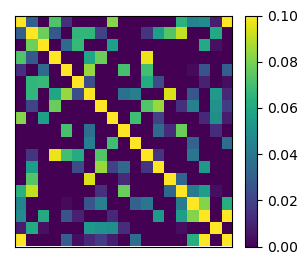

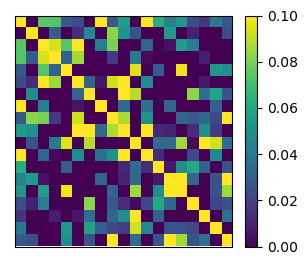

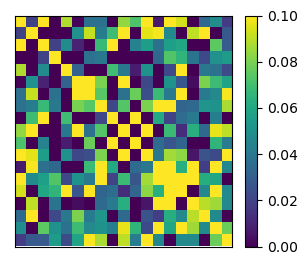

In [43]:
corr_matrix={}
for sound in sound_list:
    plt.figure(figsize=(3.5,3))
    corr_matrix[sound]=np.corrcoef(tp[sound])
    plt.imshow(corr_matrix[sound], aspect='auto', vmin=0.0, vmax=0.1)
    
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.savefig("intersubjects_correlation_matrices_temporal_profile" + sound + '.png', dpi=600)
    plt.show()
    plt.close()

sv.saving(corr_matrix, path+"intersubjects_correlation_matrices_temporal_profile")

    

436.402


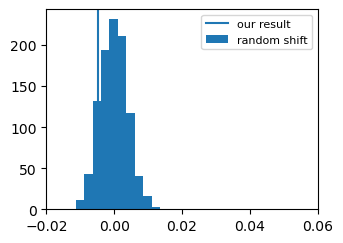

8.906


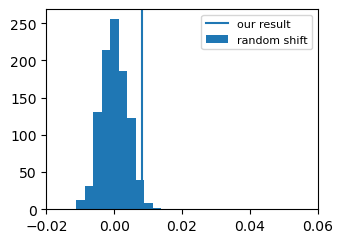

0.0


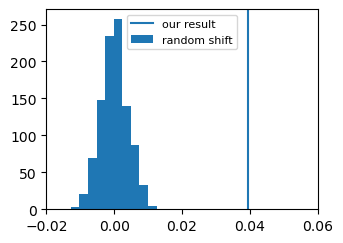

In [42]:
dataused='windows150_shifting60'
list_mean_corr={}

num_it=1000
for sound in sound_list:
    list_mean_corr[sound]=[]

    for i in range(num_it):

        tp_shift=av.shifting_matrix(tp[sound])
        list_mean_corr[sound].append(np.mean(np.corrcoef(tp_shift)[np.triu_indices(19, k = 1)]))

sv.saving(list_mean_corr, path+"list_mean_corr_surrogate_temporal_profile")

for sound in sound_list:
    print(np.sum(np.where(np.array(list_mean_corr[sound])>np.mean(corr_matrix[sound][np.triu_indices(19, k = 1)])))/1000)

    plt.figure(figsize=(3.5,2.6))
    plt.hist(list_mean_corr[sound], label='random shift')
    plt.axvline(x=np.mean(corr_matrix[sound][np.triu_indices(19, k = 1)]), label='our result')
    plt.legend(fontsize=8)
    plt.xlim((-0.02,0.06))
    plt.savefig('comparison_null_music_env_'+dataused+sound+'.png', dpi=600)
    plt.show()
    plt.close()
    


0.877


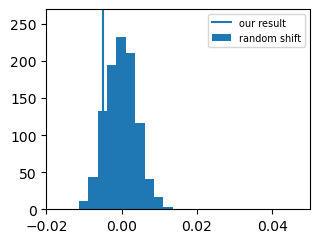

0.019


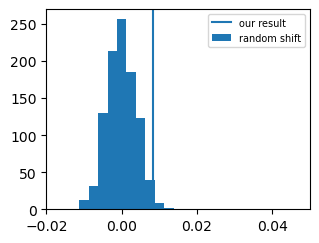

0.0


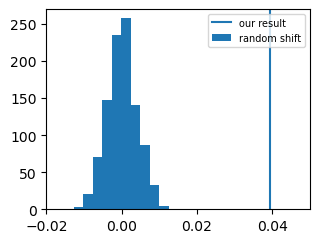

In [44]:

for sound in sound_list:
    print(np.sum(np.where(np.array(list_mean_corr[sound])>np.mean(corr_matrix[sound][np.triu_indices(19, k = 1)]),1,0))/1000)

    plt.figure(figsize=(3.4,2.6))
    plt.hist(list_mean_corr[sound], label='random shift')
    plt.axvline(x=np.mean(corr_matrix[sound][np.triu_indices(19, k = 1)]), label='our result')
    plt.legend(fontsize=7)
    plt.xlim((-0.02,0.05))
    plt.ylim((0,270))
    plt.savefig('comparison_null_music_temp_intersub_corr_'+dataused+sound+'.png', dpi=600)
    plt.show()
    plt.close()
    

In [28]:
np.sum(np.where(np.array(list_mean_corr['music'])>np.mean(corr_matrix['music'][np.triu_indices(19, k = 1)]), 1, 0))

26

Here we compute the activity profile, in time windows of the same size as the ones of the temporal profile.

In [24]:
len(zdata['rest'][0,:])/350


161.9142857142857

In [26]:
L = 350 # window length for fitting
sp = 350 # window spacing
ap={}
for subject in subject_list:
    ap[subject]={}
    for sound in sound_list:
        
        tlen=len(rss[subject][sound])
        W_L = np.arange(0,tlen-int(L/2),int(sp/2)) # start times of windows, spaced every sp time points
        n_W = W_L.size # number of windows
        magt=np.zeros(n_W) 
        for i in range(n_W):
            t_start = W_L[i]
            t_stop = t_start + L
            dat=rss[subject][sound][t_start:t_stop]
            magt[i]=np.sum(dat)
            
    
        ap[subject][sound]=magt

In [32]:
for subject in subject_list:
    
    for sound in sound_list:
        if len(ap[subject][sound])!=len(tp[subject][sound]):
            print('ops')

In [14]:

corr={}

corr['p']={}
corr['e']={}
for sound in sound_list:
    
    cor=[]
    co=[]
    
    for subject in subject_list:
        
        a=ap[subject][sound]
        b=tp[subject][sound]
        c=ae[subject][sound]
        d=te[subject][sound]
        m=min(len(a),len(b))
        
        cor.append(np.corrcoef(a[:m], b[:m])[0,1])
        co.append(np.corrcoef(c,d)[0,1])
    
    corr['p'][sound]=np.array(cor)
    corr['e'][sound]=np.array(co)

        

#%%Plotting the result


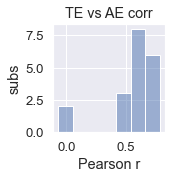

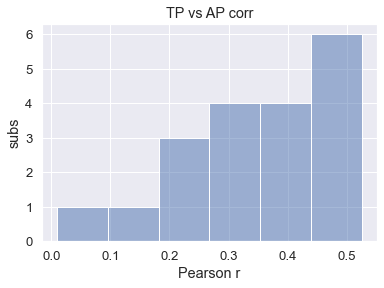

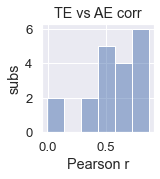

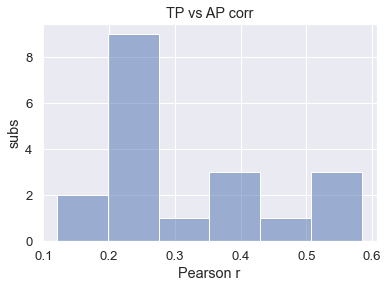

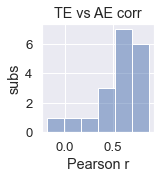

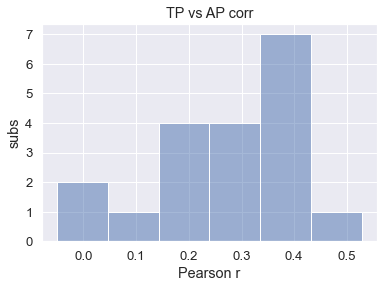

In [16]:
correlation={}
import seaborn as sns
for sound in sound_list:
    sns.set(font_scale=1.2)
    correlation['e']=pd.DataFrame({sound:corr['e'][sound]})
    correlation['p']=pd.DataFrame({sound:corr['p'][sound]})
    plt.figure(figsize=(2,2))
    sns.histplot(correlation['e'],legend=False).set(title='TE vs AE corr')
    plt.xlabel('Pearson r')
    plt.ylabel('subs')
    plt.savefig(path + 'figure/intersubject_correlation_TPAP', dpi=600)
    plt.show()
    plt.close()
    sns.histplot(correlation['p'],legend=False).set(title='TP vs AP corr')
    plt.xlabel('Pearson r')
    plt.ylabel('subs')
    plt.savefig(path + 'figure/intersubject_correlation_TEAE', dpi=600)
    plt.show()
    plt.close()


In this part we are going to study the Time Engagement and the Activity Engagement. We are going to see that those two measures correlate

<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (127,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (17,), type "|S13">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (166,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (19,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (152,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (36,), type "|S13">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (150,)


<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (127,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (17,), type "|S13">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (166,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (19,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (152,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (36,), type "|S13">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (150,)


<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (41,), type "|S13">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (127,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (17,), type "|S13">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (166,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (19,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'dismissed', 'mayavi', 'original']>
chnames (152,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-ele

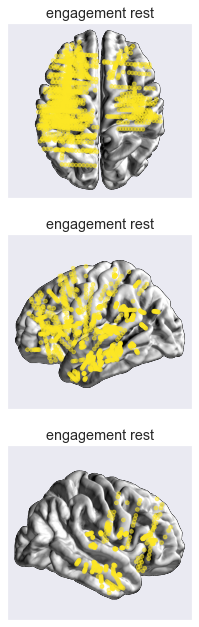

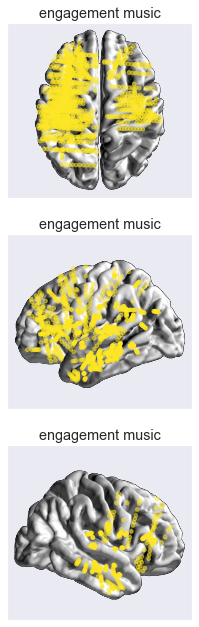

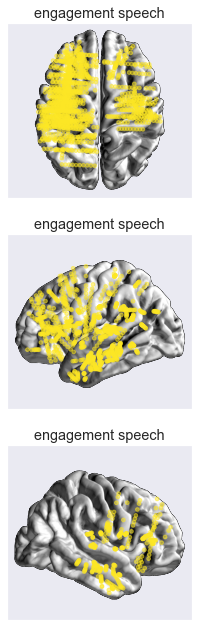

In [55]:

        
for o, sound in enumerate(['rest','music', 'speech']):
    
    ma=max(maxx[o::3])
    mi=min(minn[o::3])
    
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list[:10]):            
            
            eng=(te[subject][sound]-mi)/max(te[subject][sound]-mi)
            
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                print(f.keys())
                print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                print(f.keys())
                print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(te[subject][sound][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.viridis((te[subject][sound][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(te[subject][sound][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.viridis((te[subject][sound][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(te[subject][sound])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.viridis((te[subject][sound]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=cmap, s=55*np.ones(len(x_h)), marker='.', alpha=0.5)
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=cmap, s=55*np.ones(len(x_h)), marker='.', alpha=0.5)
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=cmap, s=55*np.ones(len(x_h)), marker='.', alpha=0.5)

                
            axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])
    
    plt.tight_layout()
    plt.savefig(path+'figure/brain_plots_te'+orientation+'.png', dpi=600)


In [41]:
len(maxx[2::3])


19